In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io # pip install scikit-image
import os
import glob
import random
# from google.colab import files

from sklearn.preprocessing import StandardScaler, normalize

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K

In [2]:
%matplotlib inline

In [3]:
# data of brain MRI and corresponding mask
df_brain = pd.read_csv('data_mask.csv')

In [4]:
print(df_brain.shape)
df_brain.info()

(3929, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
patient_id    3929 non-null object
image_path    3929 non-null object
mask_path     3929 non-null object
mask          3929 non-null int64
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
df_brain.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [6]:
df_brain['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

Unbalanced dataset
healthy: 2556
w/ tumor: 1373

([<matplotlib.axis.XTick at 0x1e713866208>,
 [Text(0, 0, 'w/out tumor'), Text(1, 0, 'w/ tumor')])

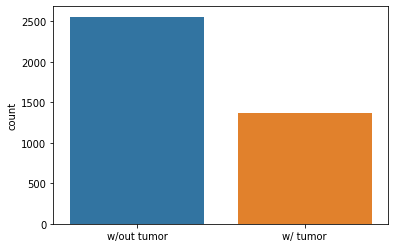

In [7]:
sns.barplot(x=df_brain['mask'].value_counts().index, y=df_brain['mask'].value_counts())
plt.ylabel('count')
plt.xticks([0,1], labels=['w/out tumor', 'w/ tumor'])

Text(0.5, 1.0, 'Overlap')

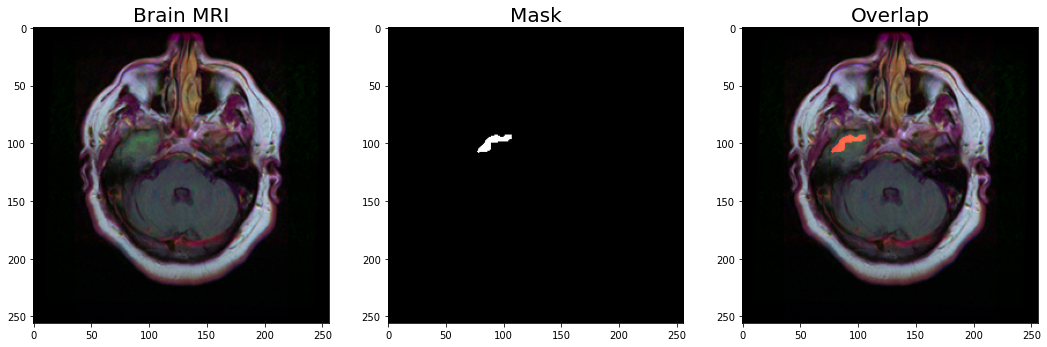

In [8]:
"""Image Visualization"""
fig = plt.figure(figsize=(18, 6))

raw = cv2.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_brain.image_path[623])
mask = cv2.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_brain.mask_path[623])
# create a red mask for overlapping
mask_red = np.copy(mask) # create a copy of the mask so the original mask does not become red
mask_red[:,:,1:]=0
overlap = cv2.addWeighted(raw, 1, mask_red, 1, 0) #(1st array, weight 1, 2nd array, weight 2, scaler to the sum)

ax1 = fig.add_subplot(131)
ax1.imshow(raw)
ax1.set_title('Brain MRI', fontsize=20)
ax2 = fig.add_subplot(132)
ax2.imshow(mask)
ax2.set_title('Mask', fontsize=20)
ax3 = fig.add_subplot(133)
ax3.imshow(overlap)
ax3.set_title('Overlap', fontsize=20)

In [9]:
df_brain_data = df_brain.drop(columns=['patient_id'])

In [10]:
df_brain_data.dtypes

image_path    object
mask_path     object
mask           int64
dtype: object

In [11]:
# convert data in mask column to string format, to use categorical mode in flow_from_dataframe
df_brain_data['mask'] = df_brain_data['mask'].astype(str)
df_brain_data.dtypes

image_path    object
mask_path     object
mask          object
dtype: object

In [12]:
# split the data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_brain_data, test_size=0.2)

In [13]:
# create an image generator
from keras_preprocessing.image import ImageDataGenerator

# create a data generator which scales the data from 0 to 1 and make validation split
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [14]:
train_generator = datagen.flow_from_dataframe(
                    dataframe=train,
                    directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
                    x_col='image_path',
                    y_col='mask',
                    subset='training',
                    batch_size=16,
                    shuffle=True, # shuffle the data so the order is not used as information for training
                    class_mode='categorical',
                    target_size=(256,256))

valid_generator = datagen.flow_from_dataframe(
                    dataframe=train,
                    directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
                    x_col='image_path',
                    y_col='mask',
                    subset='validation',
                    batch_size=16,
                    shuffle=True,
                    class_mode='categorical',
                    target_size=(256,256))

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(
                    dataframe=test,
                    directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
                    x_col='image_path',
                    y_col='mask',
                    subset='training',
                    batch_size=16,
                    shuffle=False, # no need to shuffle the test data as we don't use it for training
                    class_mode='categorical',
                    target_size=(256,256))

Found 2515 validated image filenames belonging to 2 classes.
Found 628 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [15]:
# get the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

weights: the ResNet50 model was pre-trained on the ImageNet dataset
include_top: don't include the dense layer

In [ ]:
base_model.summary()

In [20]:
# freeze the model weights
for layer in base_model.layers:
    layer.trainable = False

In [26]:
# add classification head to the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

In [ ]:
model.summary()

In [28]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# use early stopping to exit training if validation loss is not decreasing after certain epochs(patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier_resnet_weights.hdf5', verbose=1, save_best_only=True)

In [35]:
print(train_generator.n, valid_generator.n)

2515 628


2515//16 = 157 -> 157 steps for training
628//16 = 39 -> 39 steps for validation

In [34]:
history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n//16,
                    epochs=200,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//16,
                    callbacks=[checkpointer, earlystopping])

Train for 157 steps, validate for 39 steps
Epoch 1/200
156/157 [============================>.] - ETA: 4s - loss: 0.7492 - accuracy: 0.7318
Epoch 00001: val_loss improved from inf to 0.79067, saving model to classifier_resnet_weights.hdf5
157/157 [==============================] - 836s 5s/step - loss: 0.7485 - accuracy: 0.7311 - val_loss: 0.7907 - val_accuracy: 0.6795
Epoch 2/200
156/157 [============================>.] - ETA: 4s - loss: 0.3911 - accuracy: 0.8087
Epoch 00002: val_loss did not improve from 0.79067
157/157 [==============================] - 834s 5s/step - loss: 0.3903 - accuracy: 0.8087 - val_loss: 1.1179 - val_accuracy: 0.6795
Epoch 3/200
156/157 [============================>.] - ETA: 4s - loss: 0.3625 - accuracy: 0.8284
Epoch 00003: val_loss did not improve from 0.79067
157/157 [==============================] - 818s 5s/step - loss: 0.3621 - accuracy: 0.8283 - val_loss: 1.6200 - val_accuracy: 0.6795
Epoch 4/200
156/157 [============================>.] - ETA: 4s - loss

In [36]:
model_json = model.to_json()
with open('classifier_resnet_model.json', 'w') as json_file:
    json_file.write(model_json)

In [37]:
model.save('classifier_resnet_weights.h5')

In [39]:
# # load pre-trained model (instead of training the model for a long time)
# with open('classifier_resnet_model.json', 'r') as json_file:
#     json_saved_model = json_file.read()
# # load the model
# model = tf.keras.models.model_from_json(json_saved_model)
# model.load_weights('classifier_resnet_weights.hdf5')
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
# load pre-trained model (instead of training the model for a long time)
with open('resnet-50-MRI.json', 'r') as json_file:
    json_saved_model = json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# make prediction
test_predict = model.predict(test_generator, steps=test_generator.n//16, verbose=1)

49/49 [==============================] - 66s 1s/step


In [41]:
test_predict.shape

(784, 2)

In [54]:
test_predict

array([[9.9999869e-01, 1.3378460e-06],
       [1.0274758e-08, 1.0000000e+00],
       [1.0000000e+00, 5.4973665e-08],
       ...,
       [1.0000000e+00, 9.0548660e-19],
       [9.9995768e-01, 4.2320400e-05],
       [1.2831538e-15, 1.0000000e+00]], dtype=float32)

In [55]:
"""Model evaluation"""
# obtain the predicted class from model prediction (probability)
y_predict = []
for i in test_predict:
    y_predict.append(str(np.argmax(i)))
y_predict = np.asarray(y_predict)

In [48]:
len(test_predict)

784

In [56]:
# there are 786 images in test set, but we used 784 with limitation from using test generator
# which is due to batch size 16
y_test = np.asarray(test['mask'])[:len(test_predict)]
len(y_test)

784

0.9847
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       500
           1       0.99      0.96      0.98       284

    accuracy                           0.98       784
   macro avg       0.99      0.98      0.98       784
weighted avg       0.98      0.98      0.98       784



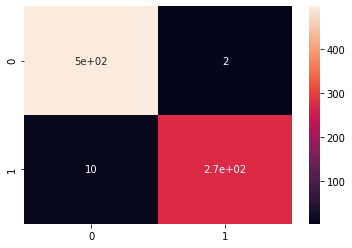

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_predict)
print('%.4f'%accuracy)

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)

print(classification_report(y_test, y_predict))